In [1]:
%matplotlib inline
%load_ext autoreload


import torch
import torch.nn.functional as F
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
from laughter_classification.sspnet_data_sampler import SSPNetDataSampler
from laughter_prediction.feature_extractors import LibrosaExtractor
from sklearn.model_selection import train_test_split
from laughter_prediction.rnn import LibrosaFeaturesRnn
from laughter_prediction.predictors import RnnPredictor
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib.pyplot as plt


In [2]:
!mkdir -p data

## Cмотирим на данные

In [3]:
directory = 'vocalizationcorpus/data'
audio_files = list(sorted(os.listdir('vocalizationcorpus/data')))

audio_file = directory + '/' + audio_files[0]
audio_file

'vocalizationcorpus/data/S0001.wav'

(128, 474)


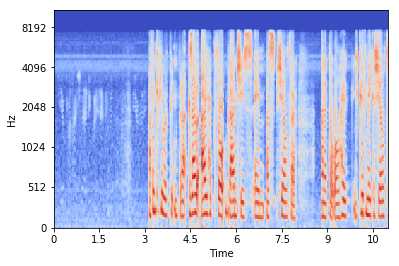

In [4]:
y, sr = librosa.load(audio_file)
S = librosa.feature.melspectrogram(y, sr)
S = librosa.power_to_db(S)

print(S.shape)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

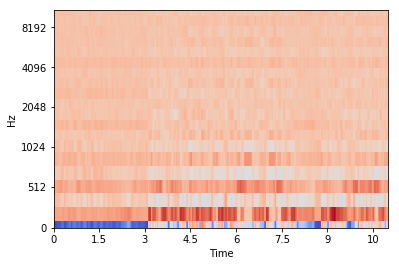

In [5]:
y, sr = librosa.load(audio_file)
S = librosa.feature.mfcc(y, sr)
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='mel')

In [6]:
extractor = LibrosaExtractor()
extractor.extract_features(audio_file).head()

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-14.770546,-7.502573,-14.677981,-10.937127,-21.269282,-39.300535,-43.299913,-38.613908,-20.862417,-16.210959,...,7.274429,11.029847,10.672556,-0.565825,19.375721,1.419888,6.978270,-2.037510,20.511622,8.859711
1,-16.770523,-8.677541,-18.883031,-33.635306,-29.146382,-23.314792,-15.536017,-10.014064,-25.719489,-35.669000,...,-16.901669,-7.184055,-19.194132,-17.970590,12.663122,-0.107084,20.268938,1.372494,-7.076095,8.931564
2,-12.352719,-4.444362,-14.673733,-42.556730,-17.731121,-11.759801,-19.046962,-15.194353,-23.255466,-19.323618,...,-11.666725,2.564224,-4.208590,-11.211039,16.965807,16.649665,23.453795,11.212921,9.460361,-13.224893
3,-15.440580,-7.917505,-18.145880,-45.599949,-29.652522,-23.691098,-19.468875,-14.010716,-25.302332,-22.604453,...,-0.191644,9.514174,-7.796018,-7.132752,11.623116,8.058064,21.677039,-1.138147,-2.169490,-5.259990
4,-18.958624,-11.360067,-18.807546,-15.593530,-23.763246,-21.985535,-24.705120,-19.680730,-22.500579,-18.102045,...,-14.405206,-4.518877,4.056877,6.588490,14.185785,-15.692512,3.539914,12.142542,9.761851,3.887359


## Считываем признаки

In [7]:
SAMPLE_RATE = 16000
FRAME_SEC = 0.3

In [8]:
sampler = SSPNetDataSampler('vocalizationcorpus')

In [9]:
data = sampler.create_sampled_df(FRAME_SEC, save_path='data/sampled.csv')

saving df:  data/sampled.csv


In [10]:
data

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-19.512337,-10.751633,-14.777827,-18.966939,-16.917103,-18.246705,-20.162993,-18.075304,-17.600648,-18.778584,...,8.756960,-14.857754,22.649179,-15.996658,12.870518,-10.768023,6.965929,-3.087592,0,S0001
1,-16.418212,-11.479087,-15.647148,-18.000653,-16.257974,-18.293827,-19.216450,-17.100311,-17.355976,-18.953886,...,9.974392,-17.866732,21.224710,-12.295156,15.577631,-11.913397,5.912433,-2.406997,0,S0001
2,-19.561318,-14.155631,-16.500950,-19.259373,-15.947509,-18.508480,-17.752083,-18.735773,-20.000116,-18.555955,...,11.887583,-15.699741,18.171677,-13.792290,8.600648,-10.910454,7.183778,-5.662854,0,S0001
3,-19.069293,-13.010108,-17.266277,-16.038272,-13.717408,-16.670910,-19.712922,-18.614219,-19.417061,-19.828697,...,6.627427,-9.134603,24.201275,-19.071646,13.919328,-5.860380,2.450502,-8.587574,0,S0001
4,-15.080133,-9.803062,-15.000448,-16.308712,-16.056597,-17.036844,-19.208406,-17.545893,-20.549559,-17.875918,...,12.126552,-17.691907,21.201253,-14.738738,12.562647,-8.362024,5.665779,-4.746374,0,S0001
5,-16.768311,-10.336495,-15.832604,-16.880480,-14.970650,-18.038281,-20.697990,-19.351725,-21.673575,-21.253379,...,11.975913,-12.901809,24.117082,-15.677362,14.176729,-4.046529,2.868359,-8.642527,0,S0001
6,-18.152393,-13.111996,-18.351703,-17.225439,-14.967807,-18.456091,-17.151680,-15.648074,-16.994343,-18.038206,...,7.246362,-14.432793,20.468048,-17.810742,9.385266,-9.466130,3.346170,-5.362977,0,S0001
7,-17.162352,-12.888983,-17.996707,-19.491615,-18.377252,-16.595850,-18.217371,-17.095571,-16.184384,-17.890604,...,9.661401,-15.591358,22.338917,-16.937508,8.823653,-13.398335,4.027778,-3.166383,0,S0001
8,-21.760583,-17.076791,-17.519815,-17.840089,-15.205841,-15.410737,-19.382010,-16.272773,-15.181722,-17.153874,...,6.881137,-13.332776,20.765922,-16.207669,8.292226,-13.345987,1.548566,-2.481757,0,S0001
9,-20.976208,-13.166227,-16.969717,-15.078048,-15.592011,-20.803412,-18.955738,-17.210551,-20.674733,-21.714713,...,12.389687,-14.276152,22.001954,-17.787656,13.491517,-8.972144,4.211393,-4.558085,0,S0001


In [11]:
sampler_noisy = SSPNetDataSampler('vocalizationcorpus_noisy/vocalizationcorpus')
data_noisy = sampler_noisy.create_sampled_df(FRAME_SEC, save_path='data/sampled_noisy.csv')

saving df:  data/sampled_noisy.csv


In [15]:
data_noisy

,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019,IS_LAUGHTER,SNAME
0,-19.512337,-10.751633,-14.777827,-18.966939,-16.917103,-18.246705,-20.162993,-18.075304,-17.600648,-18.778584,...,8.756960,-14.857754,22.649179,-15.996658,12.870518,-10.768023,6.965929,-3.087592,0,S0001
1,-16.418212,-11.479087,-15.647148,-18.000653,-16.257974,-18.293827,-19.216450,-17.100311,-17.355976,-18.953886,...,9.974392,-17.866732,21.224710,-12.295156,15.577631,-11.913397,5.912433,-2.406997,0,S0001
2,-19.561318,-14.155631,-16.500950,-19.259373,-15.947509,-18.508480,-17.752083,-18.735773,-20.000116,-18.555955,...,11.887583,-15.699741,18.171677,-13.792290,8.600648,-10.910454,7.183778,-5.662854,0,S0001
3,-19.069293,-13.010108,-17.266277,-16.038272,-13.717408,-16.670910,-19.712922,-18.614219,-19.417061,-19.828697,...,6.627427,-9.134603,24.201275,-19.071646,13.919328,-5.860380,2.450502,-8.587574,0,S0001
4,-15.080133,-9.803062,-15.000448,-16.308712,-16.056597,-17.036844,-19.208406,-17.545893,-20.549559,-17.875918,...,12.126552,-17.691907,21.201253,-14.738738,12.562647,-8.362024,5.665779,-4.746374,0,S0001
5,-16.768311,-10.336495,-15.832604,-16.880480,-14.970650,-18.038281,-20.697990,-19.351725,-21.673575,-21.253379,...,11.975913,-12.901809,24.117082,-15.677362,14.176729,-4.046529,2.868359,-8.642527,0,S0001
6,-18.152393,-13.111996,-18.351703,-17.225439,-14.967807,-18.456091,-17.151680,-15.648074,-16.994343,-18.038206,...,7.246362,-14.432793,20.468048,-17.810742,9.385266,-9.466130,3.346170,-5.362977,0,S0001
7,-17.162352,-12.888983,-17.996707,-19.491615,-18.377252,-16.595850,-18.217371,-17.095571,-16.184384,-17.890604,...,9.661401,-15.591358,22.338917,-16.937508,8.823653,-13.398335,4.027778,-3.166383,0,S0001
8,-21.760583,-17.076791,-17.519815,-17.840089,-15.205841,-15.410737,-19.382010,-16.272773,-15.181722,-17.153874,...,6.881137,-13.332776,20.765922,-16.207669,8.292226,-13.345987,1.548566,-2.481757,0,S0001
9,-20.976208,-13.166227,-16.969717,-15.078048,-15.592011,-20.803412,-18.955738,-17.210551,-20.674733,-21.714713,...,12.389687,-14.276152,22.001954,-17.787656,13.491517,-8.972144,4.211393,-4.558085,0,S0001


In [12]:
def split(df, test_size=0.1, seed=0):
    np.random.seed(seed)
    df.sort_values('SNAME')
    df_by_sname = df.groupby('SNAME')
    
    records = [record for _, record in df_by_sname]
    snames  = [sname  for sname, _ in df_by_sname]
    y = [record['IS_LAUGHTER'] for record in records]
    X = [record.drop(['IS_LAUGHTER', 'SNAME'], axis=1) for record in records]
    
    y = np.array(y)
    X = np.array([x_df.values for x_df in X], dtype=np.float)
    
    X_train, X_test, y_train, y_test, snames_train, snames_test = \
        train_test_split(X, y, snames, train_size=1. - test_size, test_size=test_size)
    return  X_train, X_test, y_train, y_test, snames_train, snames_test

## Обучаем модель на данных с шумом

In [13]:
X_rain, X_test, y_train, y_test, snames_train, snames_test = split(data_noisy)

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [16]:
print(y_train[0], snames_train[0])

pd.DataFrame(X_train[0], columns=data.columns[:-2]).head()

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] S2336


,fbank_000,fbank_001,fbank_002,fbank_003,fbank_004,fbank_005,fbank_006,fbank_007,fbank_008,fbank_009,...,mfcc_010,mfcc_011,mfcc_012,mfcc_013,mfcc_014,mfcc_015,mfcc_016,mfcc_017,mfcc_018,mfcc_019
0,-18.279837,-9.925743,-7.034727,-6.366470,-3.582562,-1.967274,-2.186619,-2.898087,-3.289914,-0.819692,...,-1.169253,-17.384172,7.527737,-6.033273,7.701181,-23.957190,3.767768,1.823572,-9.087695,-6.310789
1,-8.350764,-5.838239,-12.176471,-14.766308,-9.684821,-6.898449,-8.555903,-6.893569,-8.804226,-9.584676,...,8.890739,-5.229507,-4.702625,0.386777,3.939774,-18.231355,2.193106,4.371894,9.123777,-3.683551
2,11.359923,12.165919,11.480765,10.722380,12.210117,10.033398,12.812613,19.312832,21.964445,20.846574,...,-4.888039,-7.816252,4.843390,-13.938502,14.086315,-21.263040,7.924920,-1.231396,-1.357336,-1.102332
3,9.336116,12.117546,12.854618,10.236182,10.263695,8.408460,15.811200,21.591474,21.708506,18.546723,...,-4.029900,-9.275778,2.575881,-9.233933,17.619638,-24.482254,1.947509,4.696934,-10.371555,-4.077387
4,-12.269389,-8.890475,-14.250389,-14.873047,-13.767618,-12.472830,-11.756094,-8.592509,-7.110627,-6.701631,...,11.078050,-9.460352,-4.329575,0.001802,15.019187,-29.359874,13.769583,1.476259,-5.777022,-4.519862


In [17]:
fbank_features = sum(1 for col in data_noisy.columns if col.startswith('fbank'))
mfcc_features = sum(1 for col in data_noisy.columns  if col.startswith('mfcc'))
hidden_size = 100
batch_size = 1024
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
fbank_features, mfcc_features, hidden_size, batch_size, device

(128, 20, 100, 1024, 'cuda')

In [19]:
def window_mean(arr, k=5):
    return np.convolve(arr,np.ones(k, dtype=float) / k,'valid')

In [20]:
class LearningStats:
    def __init__(self):
        self.train_losses = []
        self.test_losses = []
        self.test_auc = []
        self.train_auc = []
        self.test_f1 = []
        self.train_f1 = []
        
    def plot(self):
        plt.plot(window_mean(self.train_losses), label='train_loss')
        plt.plot(window_mean(self.test_losses), label='test_loss')
        plt.legend()
        plt.show()

        plt.plot(window_mean(self.train_auc), label='train_auc')
        plt.plot(window_mean(self.test_auc), label='test_auc')
        plt.legend()
        plt.show()
        
        plt.plot(window_mean(self.train_f1), label='train_f1')
        plt.plot(window_mean(self.test_f1), label='test_f1')
        plt.legend()
        plt.show()

In [21]:
model_noisy = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_noisy = model_noisy.to(device)
train_iter = 1


def train_model(model, X_train, y_train, X_test, y_test, batch_size, iters=100, lr=0.02, stats=None):
    if stats is None:
        stats = LearningStats()
    
    model.set_batch_size(batch_size)
    
    y_positive = np.average(y_train)
    weight=torch.tensor([y_positive ** (-.1), 1]).to(device)
        
    def calc_loss(pred_both, pred_mfcc, y):
        y = y.reshape(-1)
        return F.nll_loss(pred_both.reshape(-1, 2), y) + \
               F.nll_loss(pred_mfcc.reshape(-1, 2), y) 
    
    n_train = batch_size
    n_test = len(X_test)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    def calc_auc(y_actual, y_score):
        return roc_auc_score(y_actual.ravel(), y_score.ravel())
    
    def calc_f1(y_actual, y_score, threshold=0.5):
        y_actual = y_actual.ravel().astype(np.int)
        y_score = y_score.ravel()
        
        y_pred = np.zeros_like(y_score, dtype=np.int)
        y_pred[y_score > threshold] = 1
        
        if np.sum(y_pred * y_actual) == 0:
            return 0.
        
        p = np.average(y_actual[y_pred == 1])
        r = np.average(y_pred[y_actual == 1])
        return 2. / (1. / p + 1. / r)
    
    X_test_tensor = torch.tensor(X_test).float().to(device)
    y_test_tensor = torch.tensor(y_test).to(device)
    
    global train_iter
    def append_stats(train_loss, train_pred, train_y_actual):
        with torch.no_grad():
            model.set_batch_size(n_test)
            
            test_pred_both, test_pred_mfcc = model.forward(X_test_tensor, device)
            test_loss = calc_loss(test_pred_both, test_pred_mfcc, y_test_tensor)
            test_loss = test_loss.cpu().detach().numpy()
            
            test_pred = test_pred_both.cpu().detach().numpy()
            test_score = np.exp(test_pred[:,:,1])
            train_score = np.exp(train_pred[:,:,1])
            
            stats.test_losses.append(test_loss)
            stats.train_losses.append(train_loss)
            stats.test_auc.append(calc_auc(y_test, test_score))
            stats.train_auc.append(calc_auc(train_y_actual, train_score))
            stats.test_f1.append(calc_f1(y_test, test_score))
            stats.train_f1.append(calc_f1(train_y_actual, train_score))
            
    for _ in range(iters):
        model.train()
        model.zero_grad()
        model.set_batch_size(batch_size)
        
        indices = np.random.choice(n_train, batch_size, replace=False)
        X_batch = torch.tensor(X_train[indices])
        X_batch = X_batch.float().to(device)
        y_actual = torch.tensor(y_train[indices])
        y_actual = y_actual.to(device)
        
        pred_both, pred_mfcc = model.forward(X_batch, device)
        
        train_loss = calc_loss(pred_both, pred_mfcc, y_actual)
        train_loss.backward()
        optimizer.step()
        
        train_loss = train_loss.cpu().detach().numpy()
        pred_both = pred_both.cpu().detach().numpy()
        y_actual = y_actual.cpu().detach().numpy()
        
        append_stats(train_loss, pred_both, y_actual)
        
        if train_iter % 50 == 0:
            print("iter {} train_loss {:.5f} test_loss {:.5}".format(train_iter, stats.train_losses[-1], stats.test_f1[-1]))
            print("iter {} train_f1 {:.5f} test_f1 {:.5}".format(train_iter, stats.train_f1[-1], stats.test_f1[-1]))
            print()
            
        if train_iter % 500 == 0:
            stats.plot()
            
        train_iter += 1
    return stats

iter 50 train_loss 0.27719 test_loss 0.0
iter 50 train_f1 0.00000 test_f1 0.0

iter 100 train_loss 0.26148 test_loss 0.0
iter 100 train_f1 0.00000 test_f1 0.0

iter 150 train_loss 0.25258 test_loss 0.0
iter 150 train_f1 0.00000 test_f1 0.0

iter 200 train_loss 0.24583 test_loss 0.0
iter 200 train_f1 0.00158 test_f1 0.0

iter 250 train_loss 0.24052 test_loss 0.0
iter 250 train_f1 0.00000 test_f1 0.0

iter 300 train_loss 0.23547 test_loss 0.0
iter 300 train_f1 0.00316 test_f1 0.0

iter 350 train_loss 0.23143 test_loss 0.01626
iter 350 train_f1 0.00943 test_f1 0.01626

iter 400 train_loss 0.22760 test_loss 0.026954
iter 400 train_f1 0.01408 test_f1 0.026954

iter 450 train_loss 0.22524 test_loss 0.047872
iter 450 train_f1 0.03110 test_f1 0.047872

iter 500 train_loss 0.22297 test_loss 0.068421
iter 500 train_f1 0.05227 test_f1 0.068421



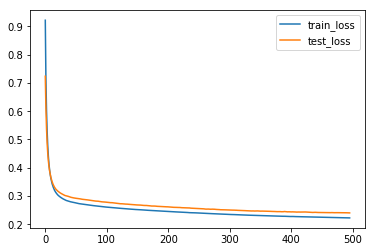

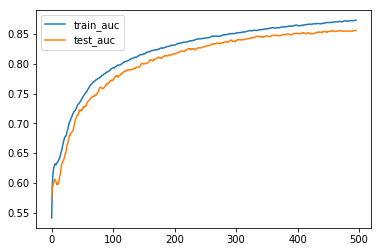

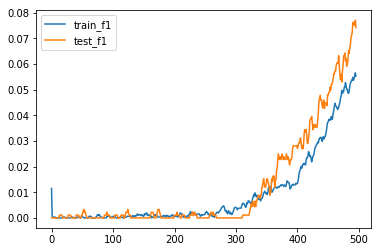

iter 550 train_loss 0.22032 test_loss 0.11253
iter 550 train_f1 0.07687 test_f1 0.11253

iter 600 train_loss 0.21855 test_loss 0.11558
iter 600 train_f1 0.09077 test_f1 0.11558

iter 650 train_loss 0.21669 test_loss 0.12871
iter 650 train_f1 0.11773 test_f1 0.12871

iter 700 train_loss 0.21465 test_loss 0.13692
iter 700 train_f1 0.12871 test_f1 0.13692

iter 750 train_loss 0.21294 test_loss 0.15572
iter 750 train_f1 0.14947 test_f1 0.15572

iter 800 train_loss 0.21146 test_loss 0.15904
iter 800 train_f1 0.16457 test_f1 0.15904

iter 850 train_loss 0.20916 test_loss 0.17661
iter 850 train_f1 0.17778 test_f1 0.17661

iter 900 train_loss 0.20802 test_loss 0.18957
iter 900 train_f1 0.18845 test_f1 0.18957

iter 950 train_loss 0.20654 test_loss 0.18957
iter 950 train_f1 0.19865 test_f1 0.18957

iter 1000 train_loss 0.20457 test_loss 0.19672
iter 1000 train_f1 0.20471 test_f1 0.19672



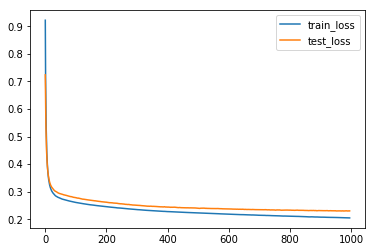

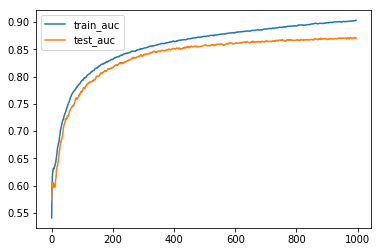

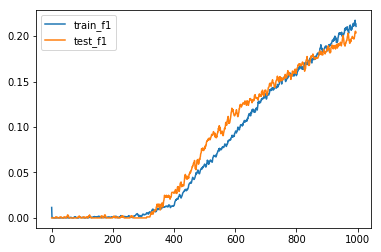

In [22]:
stats_noisy = train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

iter 1050 train_loss 0.20364 test_loss 0.21395
iter 1050 train_f1 0.23092 test_f1 0.21395

iter 1100 train_loss 0.20263 test_loss 0.21968
iter 1100 train_f1 0.23259 test_f1 0.21968

iter 1150 train_loss 0.20135 test_loss 0.2212
iter 1150 train_f1 0.24951 test_f1 0.2212

iter 1200 train_loss 0.20047 test_loss 0.23928
iter 1200 train_f1 0.23576 test_f1 0.23928

iter 1250 train_loss 0.19911 test_loss 0.2449
iter 1250 train_f1 0.26109 test_f1 0.2449

iter 1300 train_loss 0.19835 test_loss 0.25618
iter 1300 train_f1 0.25644 test_f1 0.25618

iter 1350 train_loss 0.19672 test_loss 0.25169
iter 1350 train_f1 0.26854 test_f1 0.25169

iter 1400 train_loss 0.19660 test_loss 0.26222
iter 1400 train_f1 0.27313 test_f1 0.26222

iter 1450 train_loss 0.19565 test_loss 0.27511
iter 1450 train_f1 0.28174 test_f1 0.27511

iter 1500 train_loss 0.19385 test_loss 0.27632
iter 1500 train_f1 0.28716 test_f1 0.27632



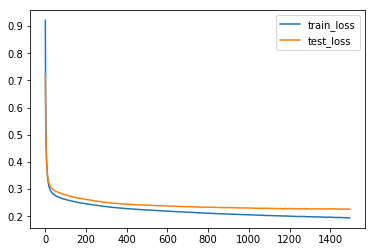

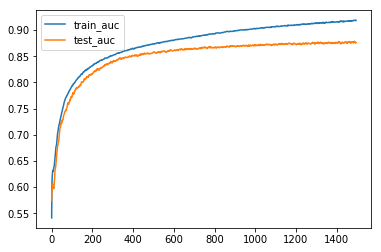

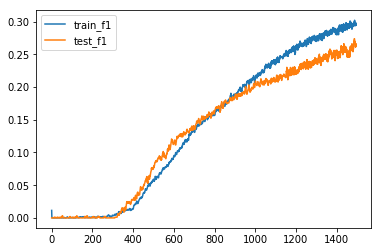

iter 1550 train_loss 0.19306 test_loss 0.28758
iter 1550 train_f1 0.28661 test_f1 0.28758

iter 1600 train_loss 0.19224 test_loss 0.28942
iter 1600 train_f1 0.29077 test_f1 0.28942

iter 1650 train_loss 0.19056 test_loss 0.29979
iter 1650 train_f1 0.29592 test_f1 0.29979

iter 1700 train_loss 0.18934 test_loss 0.28017
iter 1700 train_f1 0.29531 test_f1 0.28017

iter 1750 train_loss 0.18876 test_loss 0.28078
iter 1750 train_f1 0.30413 test_f1 0.28078

iter 1800 train_loss 0.18665 test_loss 0.27632
iter 1800 train_f1 0.31670 test_f1 0.27632

iter 1850 train_loss 0.18814 test_loss 0.31579
iter 1850 train_f1 0.29371 test_f1 0.31579

iter 1900 train_loss 0.18724 test_loss 0.30277
iter 1900 train_f1 0.32134 test_f1 0.30277

iter 1950 train_loss 0.18533 test_loss 0.31933
iter 1950 train_f1 0.32904 test_f1 0.31933

iter 2000 train_loss 0.18368 test_loss 0.29598
iter 2000 train_f1 0.33293 test_f1 0.29598



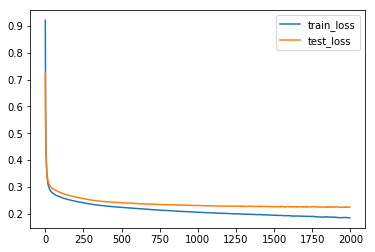

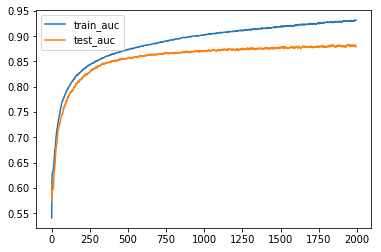

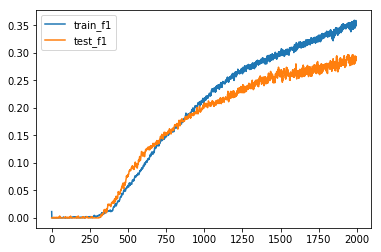

In [23]:
train_model(model_noisy, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_noisy)

In [24]:
predicted_probality = RnnPredictor(model_noisy).predict_proba(X_test, device)

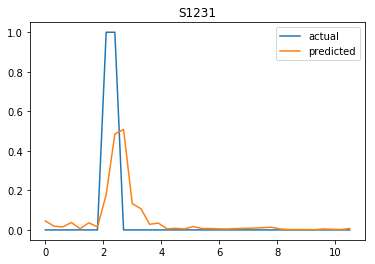

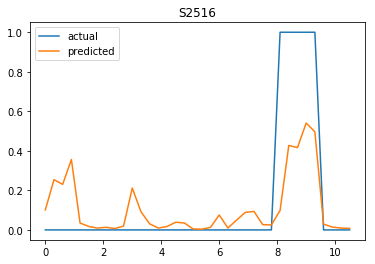

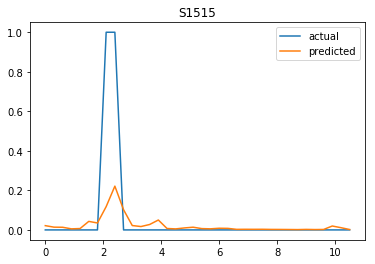

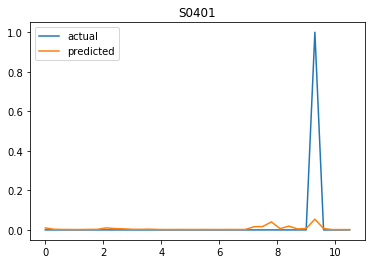

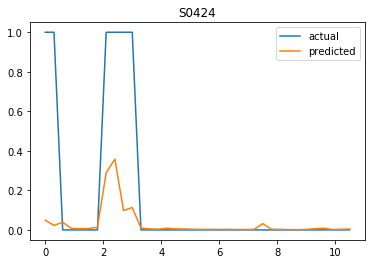

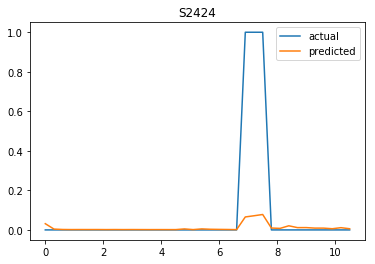

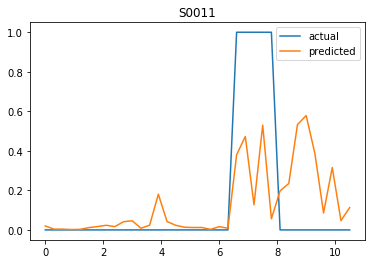

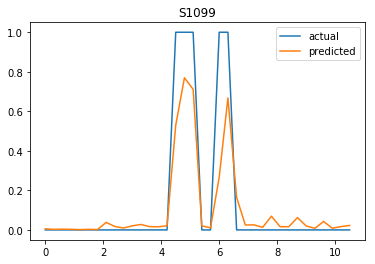

In [25]:
for sname, actual, pred in zip(snames_test[:32], y_test, predicted_probality):
    if np.sum(actual) != 0:
        plt.title(sname)
        l = len(actual)
        plt.plot(np.arange(l) * FRAME_SEC, actual, label='actual')
        plt.plot(np.arange(l) * FRAME_SEC, pred, label='predicted')
        plt.legend()
        plt.show()


## Обучаем модель на данных без добавленного шума

In [ ]:
X_train, X_test, y_train, y_test, snames_train, snames_test = split(data)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2461, 36, 148) (274, 36, 148) (2461, 36) (274, 36)


In [ ]:
model_clean = LibrosaFeaturesRnn(fbank_features, mfcc_features, 
                           hidden_size=hidden_size,
                           batch_size=batch_size)

model_clean = model_clean.to(device)
train_iter = 1

iter 50 train_loss 0.27077 test_loss 0.0
iter 50 train_f1 0.00000 test_f1 0.0

iter 100 train_loss 0.25800 test_loss 0.0
iter 100 train_f1 0.00000 test_f1 0.0

iter 150 train_loss 0.25027 test_loss 0.0
iter 150 train_f1 0.00000 test_f1 0.0

iter 200 train_loss 0.24465 test_loss 0.0
iter 200 train_f1 0.00315 test_f1 0.0

iter 250 train_loss 0.23981 test_loss 0.0
iter 250 train_f1 0.01411 test_f1 0.0

iter 300 train_loss 0.23572 test_loss 0.010782
iter 300 train_f1 0.03707 test_f1 0.010782

iter 350 train_loss 0.23159 test_loss 0.01626
iter 350 train_f1 0.04927 test_f1 0.01626

iter 400 train_loss 0.22884 test_loss 0.021505
iter 400 train_f1 0.05640 test_f1 0.021505

iter 450 train_loss 0.22609 test_loss 0.037333
iter 450 train_f1 0.07391 test_f1 0.037333

iter 500 train_loss 0.22316 test_loss 0.042553
iter 500 train_f1 0.09219 test_f1 0.042553



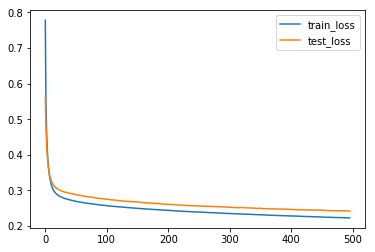

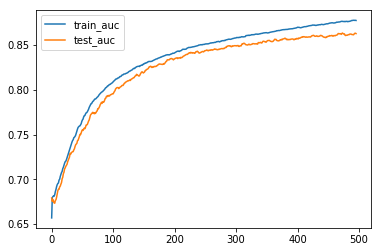

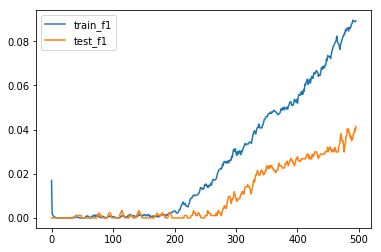

iter 550 train_loss 0.22033 test_loss 0.057895
iter 550 train_f1 0.11005 test_f1 0.057895

iter 600 train_loss 0.21781 test_loss 0.0625
iter 600 train_f1 0.13853 test_f1 0.0625

iter 650 train_loss 0.21520 test_loss 0.087179
iter 650 train_f1 0.15756 test_f1 0.087179

iter 700 train_loss 0.21343 test_loss 0.10687
iter 700 train_f1 0.17915 test_f1 0.10687

iter 750 train_loss 0.21130 test_loss 0.11028
iter 750 train_f1 0.19061 test_f1 0.11028

iter 800 train_loss 0.20998 test_loss 0.1197
iter 800 train_f1 0.20492 test_f1 0.1197

iter 850 train_loss 0.20815 test_loss 0.12968
iter 850 train_f1 0.20530 test_f1 0.12968

iter 900 train_loss 0.20597 test_loss 0.14216
iter 900 train_f1 0.20302 test_f1 0.14216

iter 950 train_loss 0.20385 test_loss 0.15049
iter 950 train_f1 0.22267 test_f1 0.15049

iter 1000 train_loss 0.20255 test_loss 0.17143
iter 1000 train_f1 0.22639 test_f1 0.17143



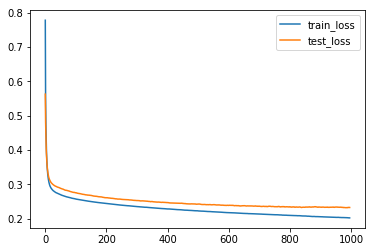

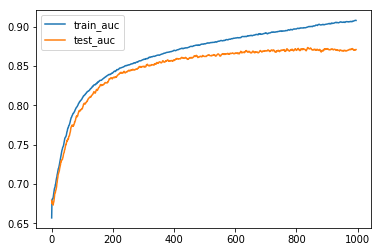

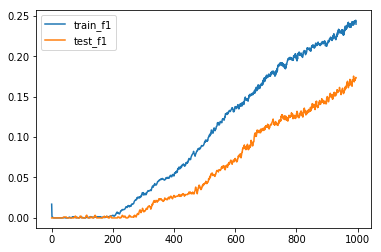

In [ ]:
stats_сlean = train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000)

iter 1050 train_loss 0.20098 test_loss 0.19026
iter 1050 train_f1 0.24538 test_f1 0.19026

iter 1100 train_loss 0.19948 test_loss 0.17225
iter 1100 train_f1 0.26933 test_f1 0.17225

iter 1150 train_loss 0.19796 test_loss 0.18095
iter 1150 train_f1 0.29100 test_f1 0.18095

iter 1200 train_loss 0.19679 test_loss 0.18483
iter 1200 train_f1 0.30462 test_f1 0.18483

iter 1250 train_loss 0.19522 test_loss 0.1934
iter 1250 train_f1 0.31409 test_f1 0.1934

iter 1300 train_loss 0.19421 test_loss 0.18052
iter 1300 train_f1 0.33333 test_f1 0.18052

iter 1350 train_loss 0.19284 test_loss 0.19477
iter 1350 train_f1 0.33679 test_f1 0.19477

iter 1400 train_loss 0.19214 test_loss 0.1949
iter 1400 train_f1 0.34217 test_f1 0.1949

iter 1450 train_loss 0.19143 test_loss 0.21461
iter 1450 train_f1 0.35667 test_f1 0.21461

iter 1500 train_loss 0.19028 test_loss 0.20882
iter 1500 train_f1 0.36985 test_f1 0.20882



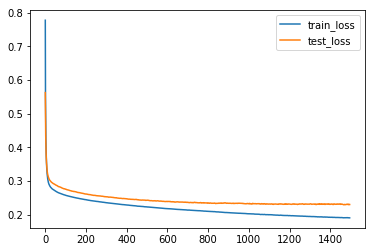

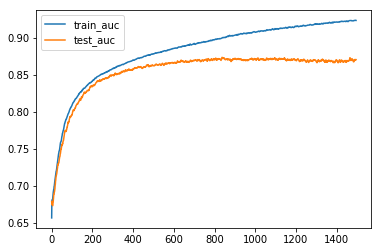

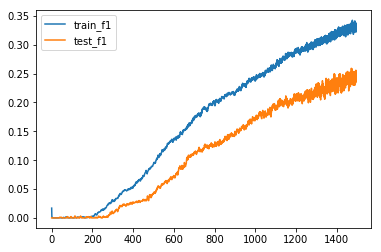

iter 1550 train_loss 0.18820 test_loss 0.19431
iter 1550 train_f1 0.37882 test_f1 0.19431

iter 1600 train_loss 0.18824 test_loss 0.20465
iter 1600 train_f1 0.37917 test_f1 0.20465

iter 1650 train_loss 0.18709 test_loss 0.21346
iter 1650 train_f1 0.39492 test_f1 0.21346

iter 1700 train_loss 0.18567 test_loss 0.21445
iter 1700 train_f1 0.39238 test_f1 0.21445

iter 1750 train_loss 0.18419 test_loss 0.21028
iter 1750 train_f1 0.40023 test_f1 0.21028

iter 1800 train_loss 0.18385 test_loss 0.23148
iter 1800 train_f1 0.40137 test_f1 0.23148

iter 1850 train_loss 0.18254 test_loss 0.2156
iter 1850 train_f1 0.40819 test_f1 0.2156

iter 1900 train_loss 0.18213 test_loss 0.24215
iter 1900 train_f1 0.42159 test_f1 0.24215

iter 1950 train_loss 0.18154 test_loss 0.25114
iter 1950 train_f1 0.42370 test_f1 0.25114

iter 2000 train_loss 0.17977 test_loss 0.23744
iter 2000 train_f1 0.42135 test_f1 0.23744



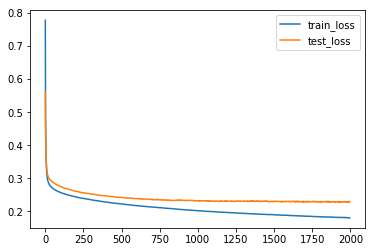

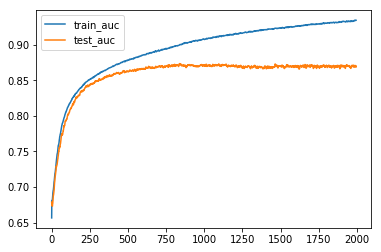

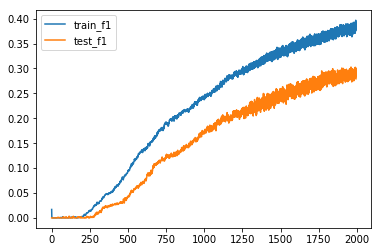

In [ ]:
train_model(model_clean, X_train, y_train, X_test, y_test, batch_size=batch_size, iters=1000, stats=stats_сlean)

## Сравнение моделей

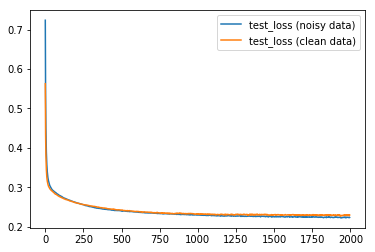

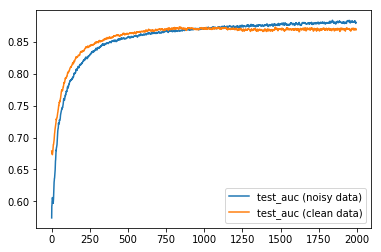

In [ ]:
plt.plot(window_mean(stats_noisy.test_losses), label='test_loss (noisy data)')
plt.plot(window_mean(stats_сlean.test_losses), label='test_loss (clean data)')

plt.legend()
plt.show()

plt.plot(window_mean(stats_noisy.test_auc), label='test_auc (noisy data)')
plt.plot(window_mean(stats_сlean.test_auc), label='test_auc (clean data)')
plt.plot(window_mean(stats_noisy.test_f1), label='test_f1 (noisy data)')
plt.plot(window_mean(stats_сlean.test_f1), label='test_f1 (clean data)')

plt.legend()
plt.show()

In [ ]:
_, X_test_noisy, _, y_test_noisy, _, sname_test_noisy = split(data_noisy)

In [ ]:
sname_test = sname_test_noisy

In [ ]:
scores_noisy = predicted_probality
scores_clean = RnnPredictor(model_clean).predict_proba(X_test_noisy, device)

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_pr_curve(testy, scores, label=''):
    plt.title('precision recall curve')
    precision, recall, thresholds = precision_recall_curve(testy, scores)
    pyplot.plot(recall, precision, label=label)
    plt.xlabel('recall')
    plt.ylabel('precision')

In [ ]:
plot_pr_curve(y_test_noisy, scores_noisy, 'noisy')
plot_pr_curve(y_test_noisy, scores_clean, 'clean')
plt.legend()
plt.show()